In [1]:
import sys

import numpy as np
import pandas as pd

from sklearn.datasets import make_regression


In [2]:
NUM_FEATURES = 100
NUM_BINS = 45
NUM_SAMPLES = 10_000
# Generate synthetic regression data
X, y = make_regression(n_samples=NUM_SAMPLES, n_features=NUM_FEATURES, noise=0.1, random_state=1)

# Convert to pandas DataFrame
df = pd.DataFrame(data=X, columns=[f'Feature_{i}' for i in range(1, NUM_FEATURES+1)])
df['Target'] = y

df_data = df.drop('Target', axis=1).astype('float32')

print(df_data.head())

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   2.669134   0.935506   0.119068   0.397455  -0.797867   1.063694   
1  -0.280565  -0.737132  -0.073916   0.266521   0.950513  -0.318143   
2  -1.545541  -0.813349   2.552004  -1.885060   1.019922  -0.546040   
3  -0.176935   1.082176   1.856537  -0.444410   0.462096   0.063075   
4   0.730443  -2.839458   0.602569  -0.249875  -1.140106  -0.024486   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_91  Feature_92  \
0   0.223034  -0.394869   0.549681    0.203443  ...   -0.977882   -0.327025   
1   2.210178  -0.486361   1.207417   -0.132859  ...   -1.732534    0.704593   
2  -0.089909  -1.040497   0.124978    0.926639  ...   -0.860770    1.445409   
3   1.173178  -0.860313   0.186985   -0.392830  ...   -0.649400   -1.150807   
4   0.068322   0.137987   1.836735   -0.455747  ...    0.026673    1.308732   

   Feature_93  Feature_94  Feature_95  Feature_96  Feature_97  Feature_98  \
0   -0.995281   -0.82

In [3]:
df_data.dtypes

Feature_1      float32
Feature_2      float32
Feature_3      float32
Feature_4      float32
Feature_5      float32
                ...   
Feature_96     float32
Feature_97     float32
Feature_98     float32
Feature_99     float32
Feature_100    float32
Length: 100, dtype: object

import os
os.environ["NUMBA_DEBUG"] = "1"

In [4]:
%%time
from ple_transformer import MyTransformerNP, MyTransformerNumba, MyTransformerCython

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 157 ms


In [5]:
%%time
import time
import pandas as pd
import gc

# helper function to test the different implementations of matrix multiplication
def test_transformer(transformer_to_test, identifier, df):
    gc.disable()
    start_time = time.time()
    transformer_to_test.transform(df)
    end_time = time.time()
    duration = end_time - start_time
    gc.enable()

    return {"transformer": identifier, "duration": duration}

test_results = []

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.78 µs


In [6]:
# setup the transformers for testing
transformer_np = MyTransformerNP(num_bins=NUM_BINS)
transformer_np.fit(df_data)
transformer_numba = MyTransformerNumba(num_bins=NUM_BINS)
transformer_numba.fit(df_data)
transformer_cython = MyTransformerCython(num_bins=NUM_BINS)
transformer_cython.fit(df_data)

# setup test scenarios
test_scenarios = [
    ("numpy", transformer_np),
    ("numba", transformer_numba),
    ("cython", transformer_cython)
]

In [7]:
%%time
# run test scenarios
for _ in range(100):
    for scenario in test_scenarios:
        test_results.append(test_transformer(scenario[1], scenario[0], df_data))

CPU times: user 1min 7s, sys: 28.6 s, total: 1min 35s
Wall time: 1min 35s


In [8]:
df_results = pd.DataFrame(test_results)

df_results = df_results.groupby('transformer').describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'transformer'}, inplace=True)
df_results.T



0         1         2
transformer          cython     numba     numpy
duration    count     100.0     100.0     100.0
            mean   0.169361  0.351953  0.434948
            std    0.004136  0.261586  0.151147
            min    0.161673  0.316282  0.404994
            25%    0.167056  0.322256  0.412994
            50%    0.168087    0.3236  0.415368
            75%     0.17059   0.32789  0.421428
            90%    0.174771    0.3334  0.433045
            95%    0.178389  0.338479  0.443563
            99%    0.184474  0.392164  0.484243
            max    0.187602  2.940553  1.926819

In [9]:
# Define the order of the categories
order = ['numpy', 'numba', 'cython']

# Convert the 'transformer' column to a categorical type
df_results['transformer'] = df_results['transformer'].astype('category')
df_results['transformer'] = df_results['transformer'].cat.set_categories(order)
df_results.sort_values('transformer', inplace=True)

# compute speed up relative to numpy
df_results['speed_up'] = df_results[df_results.transformer == 'numpy'][('duration', 'mean')].values[0] / df_results[('duration', 'mean')] 
df_results


transformer duration                                                    \
                 count      mean       std       min       25%       50%   
2       numpy    100.0  0.434948  0.151147  0.404994  0.412994  0.415368   
1       numba    100.0  0.351953  0.261586  0.316282  0.322256  0.323600   
0      cython    100.0  0.169361  0.004136  0.161673  0.167056  0.168087   

                                                     speed_up  
        75%       90%       95%       99%       max            
2  0.421428  0.433045  0.443563  0.484243  1.926819  1.000000  
1  0.327890  0.333400  0.338479  0.392164  2.940553  1.235815  
0  0.170590  0.174771  0.178389  0.184474  0.187602  2.568171

<Figure size 1000x600 with 0 Axes>

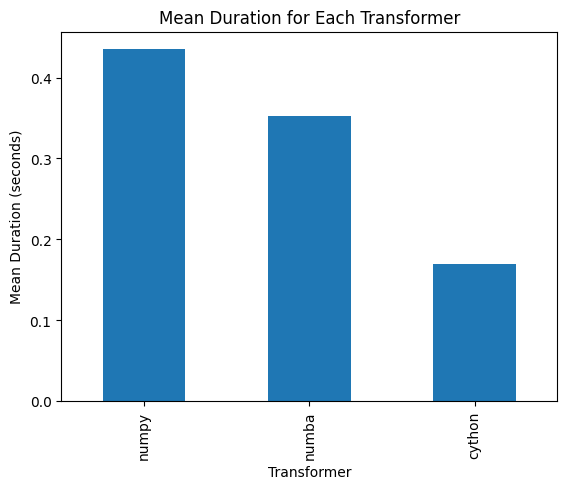

In [10]:
import matplotlib.pyplot as plt


# Sort the DataFrame by the 'transformer' column
df_results = df_results.sort_values('transformer')

# Now you can create your bar plot as before
plt.figure(figsize=(10, 6))
df_results.plot(kind='bar', x='transformer', y=('duration', 'mean'), legend=False)
plt.title('Mean Duration for Each Transformer')
plt.xlabel('Transformer')
plt.ylabel('Mean Duration (seconds)')
plt.show()

<Figure size 1000x600 with 0 Axes>

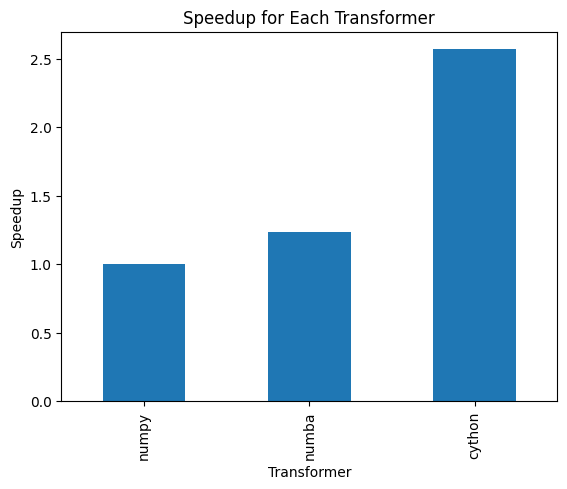

In [11]:
plt.figure(figsize=(10, 6))
df_results.plot(kind='bar', x='transformer', y='speed_up', legend=False)
plt.title('Speedup for Each Transformer')
plt.xlabel('Transformer')
plt.ylabel('Speedup')
plt.show()